In [1]:
#https://github.com/p-wojciechowski/review-rating-prediction/blob/main/notebooks/model_selection.ipynb

In [2]:
import numpy as np
import pandas as pd
import pickle


In [3]:
def balance_dataframe(df, category=['Rating']):
    """
    :param df: pandas.DataFrame
    :param categorical_columns: iterable of categorical columns names contained in {df}
    :return: balanced pandas.DataFrame
    """    
    if category is None or not all([col in df.columns for col in category]):
        raise ValueError('Please provide one or more columns containing categorical variables')

    lowest_count = (df.groupby(category).apply(lambda x: x.shape[0]).min())
#    lowest_count =250
    df = df.groupby(category).apply( 
        lambda x: x.sample(lowest_count)).drop(category, axis=1).reset_index().set_index('level_1')

    df.sort_index(inplace=True)

    return df

In [4]:
df_reviews = pd.read_csv("Train.csv")

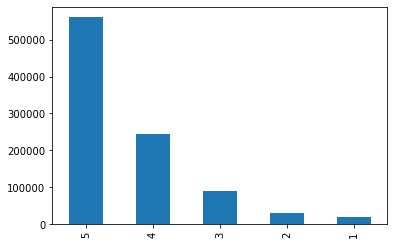

In [5]:
df_reviews['Rating'].value_counts().plot.bar()

In [6]:

df_reviews['len'] = df_reviews.reviewText.str.len()

df_reviews = df_reviews[df_reviews['len'].between(10, 4000)]
df_reviews[['Rating']] = df_reviews[['Rating']].apply(pd.to_numeric)

print("(pre) 1 star ratings: %d" % (len(df_reviews[df_reviews.Rating == 1])))
print("(pre) 2 star ratings: %d" % (len(df_reviews[df_reviews.Rating == 2])))
print("(pre) 3 star ratings: %d" % (len(df_reviews[df_reviews.Rating == 3])))
print("(pre) 4 star ratings: %d" % (len(df_reviews[df_reviews.Rating== 4])))
print("(pre) 5 star ratings: %d" % (len(df_reviews[df_reviews.Rating == 5])))
print("######AFTER#####")
df_balanced = balance_dataframe(df_reviews, 
                                category=['Rating'])

df_balanced.to_csv('balanced.csv', encoding='utf-8')
print("(post) 1 star ratings: %d" % (len(df_balanced[df_balanced.Rating == 1])))
print("(post) 2 star ratings: %d" % (len(df_balanced[df_balanced.Rating == 2])))
print("(post) 3 star ratings: %d" % (len(df_balanced[df_balanced.Rating == 3])))
print("(post) 4 star ratings: %d" % (len(df_balanced[df_balanced.Rating == 4])))
print("(post) 5 star ratings: %d" % (len(df_balanced[df_balanced.Rating == 5])))

(pre) 1 star ratings: 20880
(pre) 2 star ratings: 30752
(pre) 3 star ratings: 90393
(pre) 4 star ratings: 241721
(pre) 5 star ratings: 557002
######AFTER#####
(post) 1 star ratings: 20880
(post) 2 star ratings: 20880
(post) 3 star ratings: 20880
(post) 4 star ratings: 20880
(post) 5 star ratings: 20880


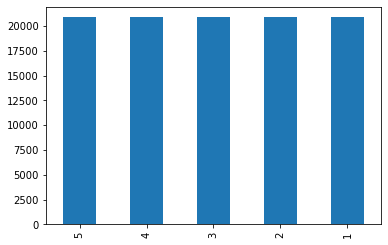

In [7]:
df_balanced['Rating'].value_counts().plot.bar()

In [8]:
del  df_reviews,df_balanced

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

C:\Users\alita\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\alita\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\alita\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\alita\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.


# EDA
In this part, we will make some basic insights into the dataset. First, let's see the structure of dataset. There are 20491 hotel reviews together with ratings (scale from 1 to 5) that were given along with the reviews. Most of them are reviews with ratings "4" and "5".

In [10]:
raw = pd.read_csv('balanced.csv')
df = raw.copy()
raw

,level_1,Rating,ProductID,reviewText,reviewTime,reviewerID,summary,len
0,4,5,B008O8ARTO,"As soon as I'm on the edge of my seat, it's ov...",24-Mar-45,A27HTFG0450FR0,I like these stories,97.0
1,8,3,B0060M8GYY,"I would probably only give it 2 1/2, my kindle...",18-Jun-46,A30X55GM6RO1XJ,Strange...,137.0
2,29,1,B00EURJ910,This book was so slow that I just couldn't get...,21-Mar-46,A1YI8ILV6V4YVH,Boring!,174.0
3,62,5,B006PL9ZPY,Read it and think... Another hit from Blake -...,30-Mar-44,A2RBO5M9NZL9P7,Read!,160.0
4,74,2,B00JOV928C,Sorry to say but the author has no clue about ...,21-Nov-47,A3U4IV4EYH30H6,what army is this,147.0
...,...,...,...,...,...,...,...,...
104395,946970,2,B00FLZKDYW,SPOILERSI feel bad saying this since I liked t...,26-Aug-45,A2RKBKVSL9XJER,Crushed....!!!! ATTENTION SPOILERS!!!!,832.0
104396,946979,2,B006NQKVOA,Cat has managed to escape from a powerful drug...,20-Feb-44,A3SD7HEWV98GZV,Too choppy,2107.0
104397,947015,1,B006T3P1TM,This book was awful. First off if I ever heard...,26-Aug-45,A8DEIUNJYJG2H,This is a sorry excuse for Christian writting.,597.0
104398,947019,2,B00A15SPPQ,I got lost so many times in this book which in...,23-May-48,A25DA2MY42IEKI,How To Ask The Universe to MAnifest Your Dreams?,237.0


Rating
1    0.2
2    0.2
3    0.2
4    0.2
5    0.2
Name: Rating, dtype: float64


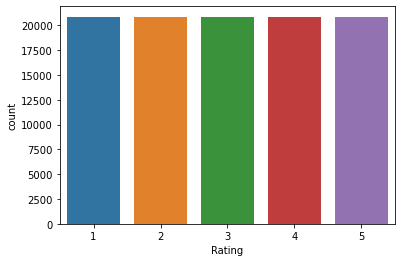

In [11]:
print(raw.groupby('Rating')['Rating'].count()/raw.shape[0])
sns.countplot(x='Rating', data=raw)
plt.show()


After preprocessing let's see the reviews' length (number of words). Most reviews (96%) are shorter than 300 words, the mean length is 101. There are many outliers - 2393.

In [12]:
df['Review'] = df['reviewText'] + df["summary"]
df['Review_length'] = df['Review'].map(lambda x: len(x.split()))
print(f'Number of outliers: {df[df.Review_length > 1.5 * df.Review_length.quantile(0.75)].shape[0]}')

Number of outliers: 15695


Basic stats of Review lengths
 count    104400.000000
mean        108.158123
std         114.184975
min           2.000000
25%          34.000000
50%          64.000000
75%         133.000000
max         785.000000
Name: Review_length, dtype: float64


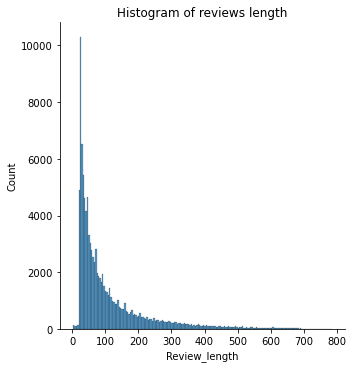

In [13]:
sns.displot(df['Review_length'])
print('Basic stats of Review lengths\n',df['Review_length'].describe())
plt.title('Histogram of reviews length')
plt.show()

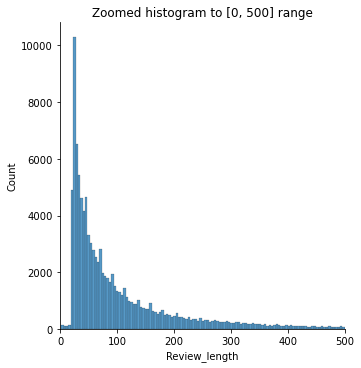

In [14]:

sns.displot(df['Review_length']).set(xlim=[0,500])
plt.title('Zoomed histogram to [0, 500] range')
plt.show()

In [15]:
x=df.groupby(df.Review_length < 250)['Review_length'].count()
print(x)
print(x[1]/(x.sum()))

Review_length
False    11138
True     93262
Name: Review_length, dtype: int64
0.8933141762452107



Let's check distributions of reviews lengths regarding Rating level. Lower ratings have much havier tails than the higher ones. Furthermore, distributions of lower-rated reviews are slightly shifted to the larger values. Among reviews with more than 300 words, ratings are more equally distributed.

In [16]:
df.groupby('Rating')['Review_length'].agg([np.mean, np.median])

,mean,median
Rating,,
1,90.135010,55
2,108.114751,65
3,116.490182,67
4,125.815182,72
5,100.235489,62


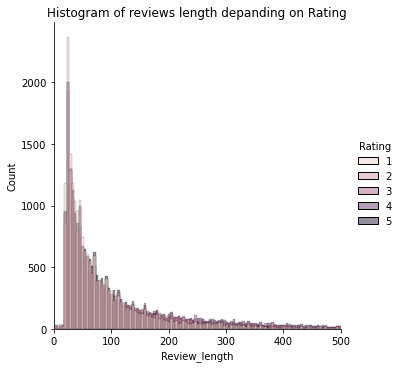

In [17]:
sns.displot(data=df, x='Review_length', hue='Rating').set(xlim=[0,500])
plt.title('Histogram of reviews length depanding on Rating')
plt.show()

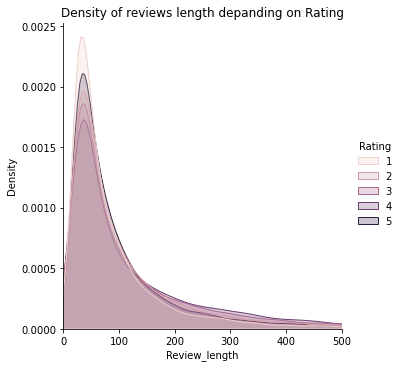

In [18]:
# denstity plot for better view of differences
sns.displot(df, x="Review_length", hue="Rating", kind="kde", fill=True).set(xlim=[0,500])
plt.title('Density of reviews length depanding on Rating')
plt.show()

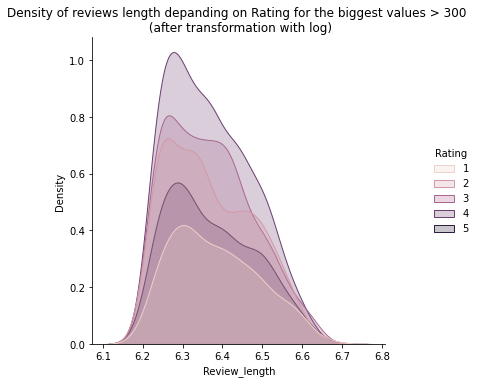

In [19]:
# distribution of the longest reviews, scaled with log
sns.displot(x=np.log(df.loc[df.Review_length>500, 'Review_length']),
            hue=df.loc[df.Review_length>500, 'Rating'], kind='kde', fill=True)
plt.title('Density of reviews length depanding on Rating for the biggest values > 300 \n (after transformation with log)')
plt.show()

# Structure of reviews
Let's see how review texts are structured regarding the sentiment of text in particular parts of review. Do medium-critical reviews praise for some elements of stay at the beginning or start from describing negative thoughts? How do start the lowest-rated reviews?

To answer this, we will use a pre-trained sentiment analyzer VADER. Before that, we tokenize and prune review length to 300 words. The best option would be to split of text according to sentences, but since there are no punctuation marks in our data set, we divide text every 4 words and analyze their sentiment. VADER returns four values: pos - positive sentiment with values[0,1], neg - negative sentiment with values [0,1], neu - neutral sentiment with values [0,1] and compound - aggregated score indicating positive or negative sentiment with values [-1,1].

In [20]:
df = raw.copy()

In [21]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
MAX_LENGTH = 300
CHUNK_SIZE = 4
MAX_CHUNK_NUMBER = int(300/CHUNK_SIZE)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alita\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [22]:
df['Review'] = df['reviewText'] + df["summary"]
def review_into_sentiment_chunks(row):
    tokenized_text = row['Review'].split()[:MAX_LENGTH]
    text_chunks = [' '.join(tokenized_text[i:i+CHUNK_SIZE]) for i in range(0, len(tokenized_text), CHUNK_SIZE)]

    polarity_scores = [analyzer.polarity_scores(x) for x in text_chunks]
    
    for feature in ['neg', 'pos', 'compound']:
        pad_vector = np.zeros(MAX_CHUNK_NUMBER)
        polarities_of_chunks = np.array([x[feature] for x in polarity_scores])
        polarities_of_chunks = polarities_of_chunks.repeat(int(MAX_CHUNK_NUMBER/len(polarities_of_chunks)))
        pad_vector[:polarities_of_chunks.shape[0]] += polarities_of_chunks
        row['sentiment_chunks_'+feature] = pad_vector
    
    return row
analyzer = SentimentIntensityAnalyzer()
df = df.apply(review_into_sentiment_chunks, axis=1)


After applying the function above we created columns with sentiment values vectors (each vector has a length of 75, one value for each chunk). Sentiment vectors shorter than 300 words are stretched to 300 for the ability to compare localization of sentiments across the review.

In [23]:

df.head()

,level_1,Rating,ProductID,reviewText,reviewTime,reviewerID,summary,len,Review,sentiment_chunks_neg,sentiment_chunks_pos,sentiment_chunks_compound
0,4,5,B008O8ARTO,"As soon as I'm on the edge of my seat, it's ov...",24-Mar-45,A27HTFG0450FR0,I like these stories,97.0,"As soon as I'm on the edge of my seat, it's ov...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,8,3,B0060M8GYY,"I would probably only give it 2 1/2, my kindle...",18-Jun-46,A30X55GM6RO1XJ,Strange...,137.0,"I would probably only give it 2 1/2, my kindle...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,29,1,B00EURJ910,This book was so slow that I just couldn't get...,21-Mar-46,A1YI8ILV6V4YVH,Boring!,174.0,This book was so slow that I just couldn't get...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,62,5,B006PL9ZPY,Read it and think... Another hit from Blake -...,30-Mar-44,A2RBO5M9NZL9P7,Read!,160.0,Read it and think... Another hit from Blake -...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,74,2,B00JOV928C,Sorry to say but the author has no clue about ...,21-Nov-47,A3U4IV4EYH30H6,what army is this,147.0,Sorry to say but the author has no clue about ...,"[0.277, 0.277, 0.277, 0.277, 0.277, 0.277, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0387, -0.0387, -0.0387, -0.0387, -0.0387, ..."



Now let's put those values into the heatmap. The color indicates mean value of sentiment on a given position. The first plot has a common color scale, the following ones do not for the sake of visibility of differences within x-star reviews.

Conclusions:

1-star reviews have the most negative remarks at the beginning of the review. At the end, there are more neutral/positive sentences (look at the last plot).

2-star reviews start with some negative conclusions, followed by some positive words of praise, and then probably explain the lower rating (mild negative sentiment)

a similar pattern is visible in case of 3-star reviews, however not as clearly as 2-star reviews and sentiments are more positive overall

4-start and 5-star reviews start with very positive opinions, the rest of review is more neutral marked

Conclusion for future modeling: It seems that each x-star group has its own pattern of sentiment values localization. Thus, information on the spatiality across review will be very important and solutions that lose it, like bag-of-words, shouldn't be used.

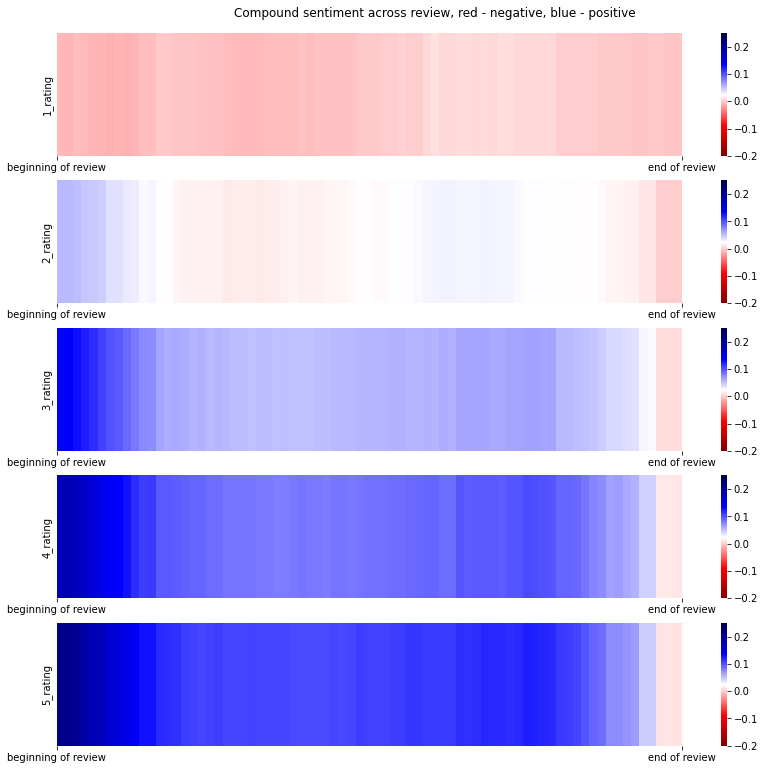

In [24]:
import seaborn as sns

def plot_sentiment(df, column_name, ratng, **kwargs):
    x = np.array(list(df.loc[df['Rating'] == ratng, column_name].values))
    x = x.mean(axis=0)[..., np.newaxis].T
    sns.heatmap(x, **kwargs)
    
fig = plt.figure()
fig.set_size_inches(14,12)
fig.suptitle('Compound sentiment across review, red - negative, blue - positive')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
for i in range(5):
    plt.subplot(5,1, i+1)
    plot_sentiment(df, 'sentiment_chunks_compound', i+1, cmap='seismic_r', vmin=-0.20, vmax =0.25)
    plt.ylabel(str(i+1)+'_rating')
    plt.xticks([0, 75], ['beginning of review', 'end of review'])
    plt.yticks([])

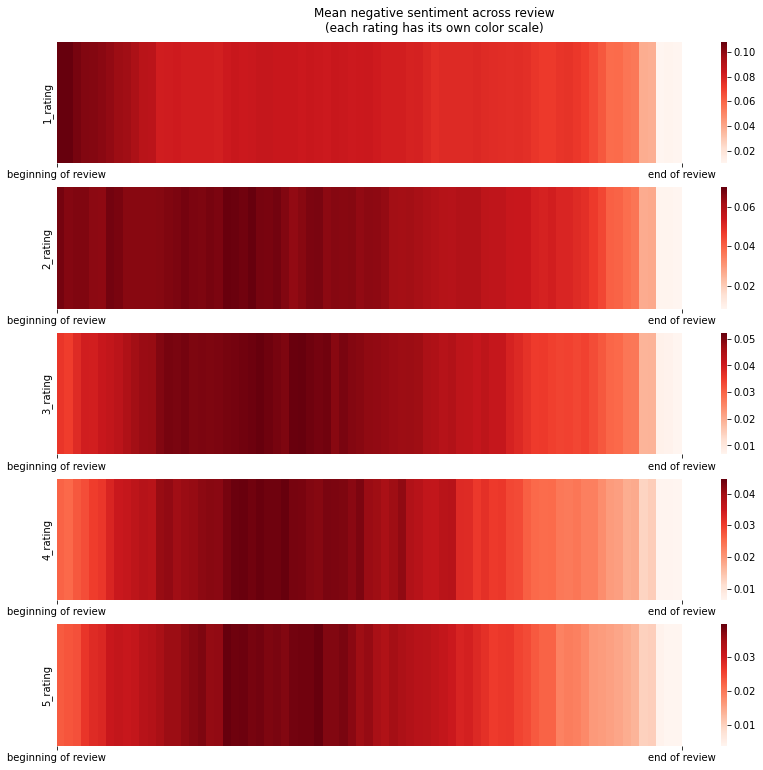

In [25]:
fig = plt.figure()
fig.set_size_inches(14,12)
fig.suptitle('Mean negative sentiment across review\n(each rating has its own color scale)')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
for i in range(5):
    plt.subplot(5,1, i+1)
    plot_sentiment(df, 'sentiment_chunks_neg', i+1, cmap='Reds')
    plt.ylabel(str(i+1)+'_rating')
    plt.xticks([0, 75], ['beginning of review', 'end of review'])
    plt.yticks([])

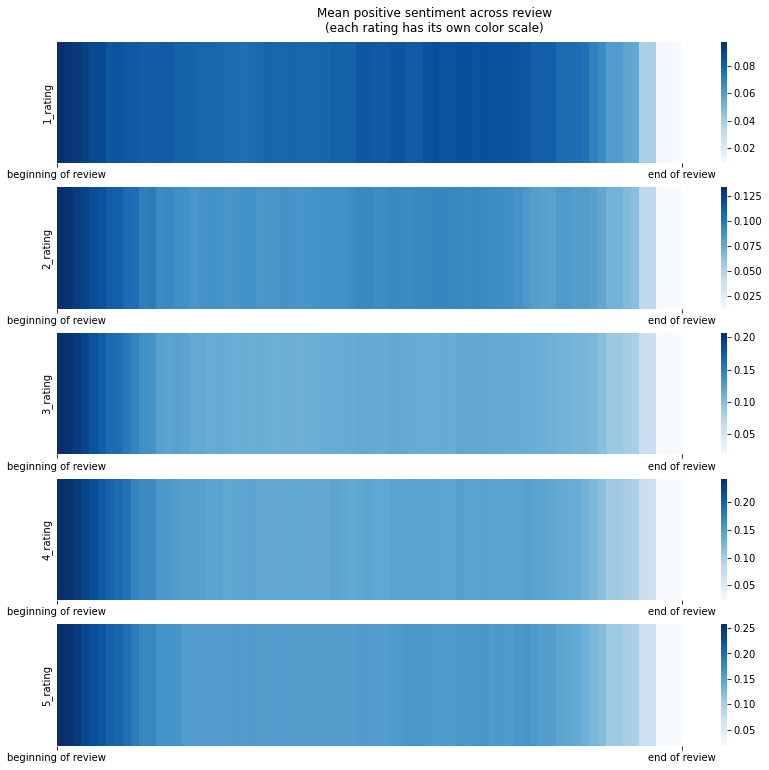

In [26]:
fig = plt.figure()
fig.set_size_inches(14,12)
fig.suptitle('Mean positive sentiment across review\n(each rating has its own color scale)')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
for i in range(5):
    plt.subplot(5,1, i+1)
    plot_sentiment(df, 'sentiment_chunks_pos', i+1, cmap='Blues')
    plt.ylabel(str(i+1)+'_rating')
    plt.xticks([0, 75], ['beginning of review', 'end of review'])
    plt.yticks([])

In [27]:
del df

In [28]:
del raw

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:

raw = pd.read_csv('balanced.csv')
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"n't", ' not', text)
    text = re.sub(r"\W|[\r\n]+", ' ', text) # remove not-words and newlines
    text = re.sub(r"\s{2,}", ' ', text) # remove '.', ',' and doubled whitespaces
    
    tokenized = [word for word in text.split() if word not in stopwords.words('english')] # remove stopwords
    text = ' '.join(tokenized)
    return text
df = raw
df['Review'] = df['reviewText'] + df["summary"]


df['Review'] = df['Review'].map(preprocess_text)
df['Review_length'] = df['reviewText'].map(lambda x: len(x.split()))

In [31]:
del raw

In [32]:
df.to_csv('CLEANED.csv', encoding='utf-8')

In [33]:
del df

In [34]:
df = pd.read_csv('CLEANED.csv')

In [35]:
#df = df.sample(frac =.1)

In [36]:
df['Rating'].value_counts().plot.bar()

#  Logestic Reg and TFIDF

In [37]:
def _reciprocal_rank(true_labels: list, machine_preds: list):
    """Compute the reciprocal rank at cutoff k"""
    
    # add index to list only if machine predicted label exists in true labels
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_preds) if r in true_labels]

    rr = 0
    if len(tp_pos_list) > 0:
        # for RR we need position of first correct item
        first_pos_list = tp_pos_list[0]
        
        # rr = 1/rank
        rr = 1 / float(first_pos_list)

    return rr

def compute_mrr_at_k(items:list):
    """Compute the MRR (average RR) at cutoff k"""
    rr_total = 0
    
    for item in items:   
        rr_at_k = _reciprocal_rank(item[0],item[1])
        rr_total = rr_total + rr_at_k
        mrr = rr_total / 1/float(len(items))

    return mrr

def collect_preds(Y_test,Y_preds):
    """Collect all predictions and ground truth"""
    
    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y_preds)]
    return pred_gold_list
             
def compute_accuracy(eval_items:list):
    correct=0
    total=0
    
    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])
        
        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break
    
    
    accuracy=correct/float(len(eval_items))
    return accuracy

In [38]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import numpy as np
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    
    logging.info("Extracting features and creating vocabulary...")
    
    if "binary" in type:
        
        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    elif "counts" in type:
        
        # COUNT BASED FEATURE REPRESENTATION
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    else:    
        
        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

def get_top_k_predictions(model,X_test,k):
    
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)

    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]
    
    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    
    preds=[ item[::-1] for item in preds]
    
    return preds
   
    
def train_model(df,field="reviewText",feature_rep="binary",top_k=3):
    
    logging.info("Starting model training...")
    
    # GET A TRAIN TEST SPLIT (set seed for consistent results)
    training_data, testing_data = train_test_split(df,random_state = 500,)

    # GET LABELS
    Y_train=training_data['Rating'].values
    Y_test=testing_data['Rating'].values
     
    # GET FEATURES
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)

    # INIT LOGISTIC REGRESSION CLASSIFIER
    logging.info("Training a Logistic Regression Model...")
    scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
    model=scikit_log_reg.fit(X_train,Y_train)

    # GET TOP K PREDICTIONS
    preds=get_top_k_predictions(model,X_test,top_k)
    
    # GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS - for ease of evaluation
    eval_items=collect_preds(Y_test,preds)
    
    # GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    mrr_at_k=compute_mrr_at_k(eval_items)
    
    logging.info("Done training and evaluation.")
    
    return model,feature_transformer,accuracy,mrr_at_k


# Baseline model¶
First, let's establish baseline models. These can be median- and mean-based dummy models:

In [39]:
y_test = df["Rating"]

In [40]:
from sklearn.metrics import mean_squared_error
print("Mean-based baseline model for test set:")
BMSE = mean_squared_error(y_test, np.repeat(y_test.mean(), len(y_test)), squared=False)
print(BMSE)
print("Median-based baseline model for test set:")
print(mean_squared_error(y_test, np.repeat(y_test.median(), len(y_test)), squared=False))

Mean-based baseline model for test set:
1.4142135623730951
Median-based baseline model for test set:
1.4142135623730951


In [41]:
data = {'MODEL':['Mean-based baseline'],
        'MSE':[BMSE]}
  
# Create DataFrame
MSE = pd.DataFrame(data)

In [42]:
MSE

,MODEL,MSE
0,Mean-based baseline,1.414214


# 1. Model - (tfidf)

In [43]:
field='reviewText'
feature_rep='tfidf'
top_k=5

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2021-04-30 16:55:58,933 : INFO : Starting model training...
2021-04-30 16:55:58,960 : INFO : Extracting features and creating vocabulary...
2021-04-30 16:56:10,566 : INFO : Training a Logistic Regression Model...


[LibLinear]

2021-04-30 16:56:27,301 : INFO : Starting evaluation...
2021-04-30 16:56:27,354 : INFO : Done training and evaluation.



Accuracy=1.0; MRR=0.7201149425287497


In [44]:
dft =  pd.read_csv("Test.csv")

In [45]:
test_features=transformer.transform(dft["reviewText"])
pred =get_top_k_predictions(model,test_features,1)

In [46]:
dft["p"]=pred 

In [47]:
from sklearn.metrics import mean_squared_error
M1 =mean_squared_error(dft["Rating"] ,pred)
M1

1.0061463414634146

In [48]:
MSE.loc[1] = ["TFIDF"] + [M1]
MSE

,MODEL,MSE
0,Mean-based baseline,1.414214
1,TFIDF,1.006146


# 2 Model -  (binary features with description only)

In [49]:
field='reviewText'
feature_rep='binary'
top_k=5

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2021-04-30 16:56:28,351 : INFO : Starting model training...
2021-04-30 16:56:28,377 : INFO : Extracting features and creating vocabulary...
2021-04-30 16:56:39,786 : INFO : Training a Logistic Regression Model...


[LibLinear]

2021-04-30 16:58:42,830 : INFO : Starting evaluation...
2021-04-30 16:58:42,875 : INFO : Done training and evaluation.



Accuracy=1.0; MRR=0.6894763729246742


In [50]:
dft2 =  pd.read_csv("Test.csv")

In [51]:
test_features2=transformer.transform(dft2["reviewText"])
pred2 =get_top_k_predictions(model,test_features2,1)

In [52]:
dft2["p"]=pred2 

In [53]:
from sklearn.metrics import mean_squared_error
M2 =mean_squared_error(dft2["Rating"] ,pred2)

In [54]:
MSE.loc[2] = ["LOG-Reg"] + [M2]
MSE

,MODEL,MSE
0,Mean-based baseline,1.414214
1,TFIDF,1.006146
2,LOG-Reg,1.196488


In [55]:
del dft2 , dft

# Neural Network


Let's divide our data set into train and test set with 80:20 ratio and tokenize texts into integers. We will use padding to fix the sample size (one review length) to 250. Previously during EDA we observed that 95% of reviews have 300 or fewer words, moreover sequences for LSTM shouldn't be too long, thats why length is set to 250.

In [56]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

MAX_NUM_WORDS = 10000
MAX_VECTOR_LEN = 150

x_train, x_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.20, random_state=42)
a = x_train
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)


x_train = pad_sequences(x_train, padding='post', maxlen=MAX_VECTOR_LEN)
x_test = pad_sequences(x_test, padding='post', maxlen=MAX_VECTOR_LEN)

In [57]:
# exemplary review after transformations
x_train[100]

array([  67,    8,   21,   42,   24,    2,   74,  290, 3491,   33,  126,
        595,  201,  341,  121, 2599, 2961,  368,   83,  201,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])


Importing pre-train word vectors created with GloVe algorithm to create embedding matrix. glove.6B.300d.txt contains 400,000 words represented in 300-dimensional vectors. Among 5000 words in our vocabulary, only 71 weren't present in the GloVe file. Now our vocabulary is mapped into 300d vector space.

In [58]:

embedding_dict = dict()
with open('glove.6B.300d.txt', encoding='utf8') as file:
    for line in file:
        splitted_line = line.split()
        word = splitted_line[0]
        vector_vals = np.asarray(splitted_line[1:], dtype='float32')
        embedding_dict[word] = vector_vals

In [59]:

embedding_matrix = np.zeros((MAX_NUM_WORDS, 300))
non_found_counter = 0
for word, index in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None and index < MAX_NUM_WORDS:
        embedding_matrix[index] = embedding_vector
    if embedding_vector is None and index < MAX_NUM_WORDS:
        non_found_counter += 1

In [60]:
embedding_matrix.shape, non_found_counter

((10000, 300), 54)

In [61]:
# Creating a model
from keras.models import Sequential
from keras.layers import Dense

# Custom activation function
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


def custom_activation(x):
    return (K.sigmoid(x) * 4) + 1

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

# # Usage
# model = Sequential()
# model.add(Dense(32, input_dim=784))
# model.add(Activation(custom_activation, name='SpecialActivation'))
# print(model.summary())

In [62]:
x = np.linspace(-10, 10)
y = custom_activation(x)
y = np.clip(custom_activation(x), a_min=0, a_max=None)

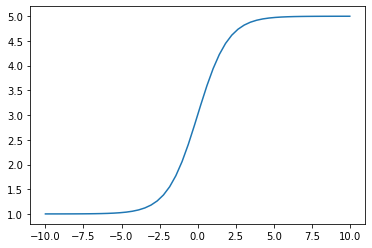

In [63]:
plt.plot(x, y)
plt.show()

In [64]:
import tensorflow as tf
def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x, inputs)
    return x

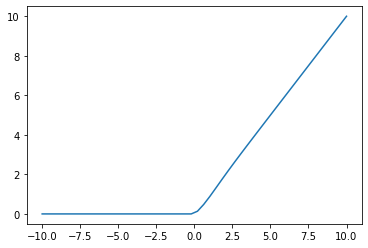

In [65]:
x = np.linspace(-10, 10)
y =  mish(x)
y = np.clip(mish(x), a_min=0, a_max=None)
plt.plot(x, y)
plt.show()

In [66]:
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [67]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [68]:
earlystop = EarlyStopping(patience=10)

In [69]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional


# Simple dense network¶
Next, let's try with the simplest neural network containing embedding layer based on previously created embedding_matrix.

# 3.with custom activation

In [70]:
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Embedding(MAX_NUM_WORDS, 300, weights=[embedding_matrix],
                          input_length=MAX_VECTOR_LEN, trainable=False),
    keras.layers.Flatten(),
    keras.layers.Dense(1,activation = mish),
    keras.layers.Dense(1,activation = custom_activation)
])
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 300)          3000000   
_________________________________________________________________
flatten (Flatten)            (None, 45000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 45001     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 3,045,003
Trainable params: 45,003
Non-trainable params: 3,000,000
_________________________________________________________________


In [71]:
from keras.callbacks import ModelCheckpoint

In [72]:
# cp=ModelCheckpoint('model_rnn_reg.hdf5',monitor='val_mean_squared_error',verbose=1,save_best_only=True)
# callbacks = [earlystop, learning_rate_reduction,cp]
# history=model.fit(x_train, y_train, validation_split=0.2,epochs=50, batch_size=64,callbacks=callbacks,verbose=2)

In [73]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2,verbose=0)

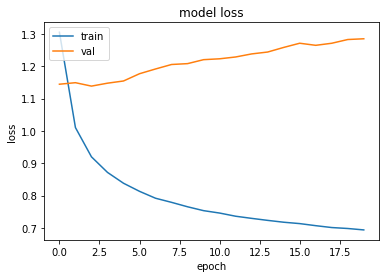

In [74]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [75]:
model3 = model
y_pred =model3.predict(x_test)
from sklearn.metrics import mean_squared_error
M3= mean_squared_error(y_test, y_pred)

In [76]:
MSE.loc[3] = ["SIMPLE-With-ACTIVATION"] + [M3]
MSE

,MODEL,MSE
0,Mean-based baseline,1.414214
1,TFIDF,1.006146
2,LOG-Reg,1.196488
3,SIMPLE-With-ACTIVATION,1.303524


# 4.without custom activation

In [77]:
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Embedding(MAX_NUM_WORDS, 300, weights=[embedding_matrix],
                          input_length=MAX_VECTOR_LEN, trainable=False),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 45000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 45001     
Total params: 3,045,001
Trainable params: 45,001
Non-trainable params: 3,000,000
_________________________________________________________________


In [78]:
history = model.fit(x_train, y_train, batch_size=32, epochs=50, verbose=0, validation_split=0.2)

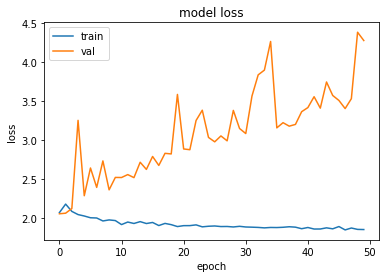

In [79]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [80]:
model4 = model
y_pred = model4.predict(x_test)
from sklearn.metrics import mean_squared_error
M4 = mean_squared_error(y_test, y_pred)

In [81]:
MSE.loc[4] = ["SIMPLE-NO-ACTIVATION"] + [M4]
MSE

,MODEL,MSE
0,Mean-based baseline,1.414214
1,TFIDF,1.006146
2,LOG-Reg,1.196488
3,SIMPLE-With-ACTIVATION,1.303524
4,SIMPLE-NO-ACTIVATION,4.407636


# CNN
Now, let's try CNN. Convolutional layers used on text can replace a forming bag of n-grams and can extract patterns from text.

# 5 Simple CNN Without Costume Activation

In [82]:
model = keras.Sequential([
    keras.layers.Embedding(MAX_NUM_WORDS, 300, weights=[embedding_matrix],
                          input_length=MAX_VECTOR_LEN, trainable=False),
    keras.layers.Conv1D(256, 5, activation='relu'),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.00005),
              loss='mean_squared_error', metrics=['mean_squared_error'],)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 146, 256)          384256    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 3,384,513
Trainable params: 384,513
Non-trainable params: 3,000,000
_________________________________________________________________


In [83]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=0, validation_split=0.2)

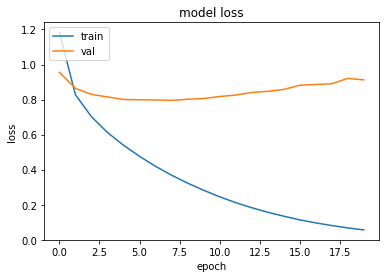

In [84]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [85]:
model5 = model
y_pred = model5.predict(x_test)
from sklearn.metrics import mean_squared_error
M5 = mean_squared_error(y_test, y_pred)

In [86]:
MSE.loc[5] = ["CNN-Simple-NO-ACTIVATION"] + [M5]
MSE

,MODEL,MSE
0,Mean-based baseline,1.414214
1,TFIDF,1.006146
2,LOG-Reg,1.196488
3,SIMPLE-With-ACTIVATION,1.303524
4,SIMPLE-NO-ACTIVATION,4.407636
5,CNN-Simple-NO-ACTIVATION,0.922910


# 6-Simple CNN With Costume Activation

In [87]:
model = keras.Sequential([
    keras.layers.Embedding(MAX_NUM_WORDS, 300, weights=[embedding_matrix],
                          input_length=MAX_VECTOR_LEN, trainable=False),
    keras.layers.Conv1D(256, 5, activation='relu'),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(1,custom_activation)
])
model.compile(optimizer='rmsprop',
              loss='mean_squared_error', metrics=['mean_squared_error'],)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 300)          3000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 256)          384256    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 3,384,513
Trainable params: 384,513
Non-trainable params: 3,000,000
_________________________________________________________________


In [88]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=0, validation_split=0.2)

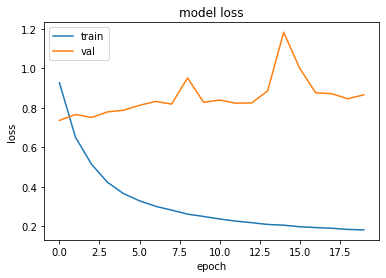

In [89]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [90]:
model6 = model
y_pred = model6.predict(x_test)
from sklearn.metrics import mean_squared_error
M6 = mean_squared_error(y_test, y_pred)

In [91]:
MSE.loc[6] = ["CNN-WITH-ACTIVATION"] + [M6]
MSE

,MODEL,MSE
0,Mean-based baseline,1.414214
1,TFIDF,1.006146
2,LOG-Reg,1.196488
3,SIMPLE-With-ACTIVATION,1.303524
4,SIMPLE-NO-ACTIVATION,4.407636
5,CNN-Simple-NO-ACTIVATION,0.922910
6,CNN-WITH-ACTIVATION,0.875534


# LSTM

# 7-Simple LSTM Without Costume Activation

In [92]:
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.models import Model

In [93]:
def RNN():
    inputs = Input(name='inputs',shape=[MAX_VECTOR_LEN])
    layer = Embedding(MAX_NUM_WORDS, 300, weights=[embedding_matrix],
                          input_length=MAX_VECTOR_LEN, trainable=False)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)

    model = Model(inputs=inputs,outputs=layer)
    return model


In [94]:
model = RNN()
model.compile(optimizer='rmsprop',
              loss='mean_squared_error', metrics=['mean_squared_error'],)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 150, 300)          3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [95]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=0, validation_split=0.2)

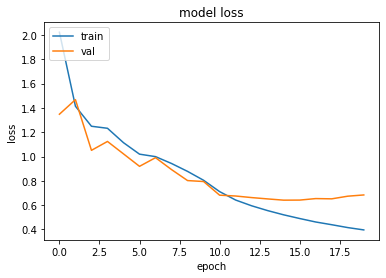

In [96]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [97]:
model7 = model
y_pred = model7.predict(x_test)
from sklearn.metrics import mean_squared_error
M7  = mean_squared_error(y_test, y_pred)

In [98]:
MSE.loc[7] = ["LSTM-NO-ACTIVATION"] + [M7]
MSE

,MODEL,MSE
0,Mean-based baseline,1.414214
1,TFIDF,1.006146
2,LOG-Reg,1.196488
3,SIMPLE-With-ACTIVATION,1.303524
4,SIMPLE-NO-ACTIVATION,4.407636
5,CNN-Simple-NO-ACTIVATION,0.922910
6,CNN-WITH-ACTIVATION,0.875534
7,LSTM-NO-ACTIVATION,0.690894


# 8-Simple LSTM With Costume Activation

In [99]:
def RNN():
    inputs = Input(name='inputs',shape=[MAX_VECTOR_LEN])
    layer = Embedding(MAX_NUM_WORDS, 300, weights=[embedding_matrix],
                          input_length=MAX_VECTOR_LEN, trainable=False)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation(custom_activation)(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model


In [100]:
model = RNN()
model.compile(optimizer='rmsprop',
              loss='mean_squared_error', metrics=['mean_squared_error'],)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 150, 300)          3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [101]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=0, validation_split=0.2)

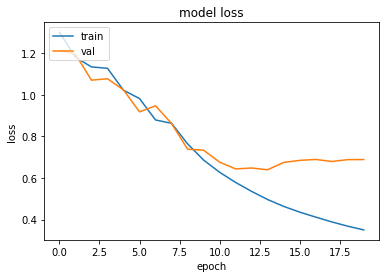

In [102]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [103]:
model8 = model
y_pred = model8.predict(x_test)
from sklearn.metrics import mean_squared_error
M8 = mean_squared_error(y_test, y_pred)

In [104]:
MSE.loc[8] = ["LSTM-WITH-ACTIVATION"] + [M8]
MSE

,MODEL,MSE
0,Mean-based baseline,1.414214
1,TFIDF,1.006146
2,LOG-Reg,1.196488
3,SIMPLE-With-ACTIVATION,1.303524
4,SIMPLE-NO-ACTIVATION,4.407636
5,CNN-Simple-NO-ACTIVATION,0.922910
6,CNN-WITH-ACTIVATION,0.875534
7,LSTM-NO-ACTIVATION,0.690894
8,LSTM-WITH-ACTIVATION,0.689199


CNN looks more promising, let's search hyperparameters for a more complex network.

# 9 CNN Searching hyperparameters no ACTivation
We will use keras tuner for searching hyperparameters. It has few different tuners which use different searching algorithms. We will use BayesianOptimization that is based on Bayesian search algorithm which is much better than simple grid search or random search.

In build_model function we specify the structure of the model and the space of parameters to search. It's important to set padding=same parameter in Conv1D and MaxPooling1D layers, because for some combinations of kernels and pooling sizes there would be dimensions error (e.g. big pool_size in previous layer reduced length of vector to 8 and next Conv1D layer has kernel with the size of 9).

I decided not to use GlobalPooling, because I wanted to preserve some level of location information on account of fact that many negative reviews begin with very few compliments.

In [131]:
# crating explicit train and validation set
x_train_smaller, x_val, y_train_smaller, y_val = train_test_split(x_train, y_train, test_size=.1, random_state=42)

In [106]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(MAX_NUM_WORDS, 300, weights=[embedding_matrix],
                          input_length=MAX_VECTOR_LEN, trainable=False))
    for i in range(hp.Int('n_layers', 1,4)):
        filters = hp.Int('filters_'+str(i), min_value=32,max_value=384,step=16)
        kernel_size = hp.Int('filter_size_'+str(i),min_value=3,max_value=9,step=2)
        pooling_size = hp.Int('pool_size_'+str(i),2,12, step=1)
        
        model.add(keras.layers.Conv1D(filters, kernel_size, activation='relu', padding='same'))
        model.add(keras.layers.MaxPooling1D(pooling_size, padding='same'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.1,
                                           max_value=0.9, step=0.1)))
    model.add(keras.layers.Dense(hp.Int('dense_units', 16, 128, step=8)))
    model.add(keras.layers.Dense(1))
#    model.add(keras.layers.Dense(1,activation=custom_activation))
   # model.add(custom_activation)
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate = hp.Choice('lr',[0.005,0.001, 0.0001, 0.00001, 0.000001])),
                  loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [107]:
import kerastuner as kt

tuner = kt.BayesianOptimization(build_model, objective='val_mean_squared_error',
                               max_trials=5,overwrite=True)
tuner.search(x_train_smaller, y_train_smaller, epochs=15, validation_data=(x_val, y_val),
            verbose=2)

Trial 5 Complete [00h 23m 01s]
val_mean_squared_error: 1.033908724784851

Best val_mean_squared_error So Far: 0.7465986609458923
Total elapsed time: 02h 10m 50s
INFO:tensorflow:Oracle triggered exit


2021-04-30 21:00:37,535 : INFO : Oracle triggered exit


In [108]:
tuner.get_best_hyperparameters(1)[0].values

{'n_layers': 3,
 'filters_0': 208,
 'filter_size_0': 5,
 'pool_size_0': 3,
 'dropout_rate': 0.1,
 'dense_units': 64,
 'lr': 0.001,
 'filters_1': 32,
 'filter_size_1': 9,
 'pool_size_1': 10,
 'filters_2': 32,
 'filter_size_2': 5,
 'pool_size_2': 5}

In [109]:
model9 = tuner.get_best_models(1)[0]
model9.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 208)          312208    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 208)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            59936     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 32)             5152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 32)             0

In [110]:
y_pred = model9.predict(x_test)

M9 =mean_squared_error(y_test, y_pred)

In [112]:
MSE.loc[9] = ["CNN_HP_NO_ACT"] + [M9]
MSE

,MODEL,MSE
0,Mean-based baseline,1.414214
1,TFIDF,1.006146
2,LOG-Reg,1.196488
3,SIMPLE-With-ACTIVATION,1.303524
4,SIMPLE-NO-ACTIVATION,4.407636
5,CNN-Simple-NO-ACTIVATION,0.922910
6,CNN-WITH-ACTIVATION,0.875534
7,LSTM-NO-ACTIVATION,0.690894
8,LSTM-WITH-ACTIVATION,0.689199
9,CNN_HP_NO_ACT,0.743151


In [ ]:
#tf.keras.models.save_model(cnn_model, './cnn_model')

In [168]:
import shutil
# shutil.make_archive('cnn_model.zip', 'zip', './cnn_model')

#  10 CNN Searching hyperparameters With ACTivation

In [132]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(MAX_NUM_WORDS, 300, weights=[embedding_matrix],
                          input_length=MAX_VECTOR_LEN, trainable=False))
    for i in range(hp.Int('n_layers', 1,4)):
        filters = hp.Int('filters_'+str(i), min_value=32,max_value=384,step=16)
        kernel_size = hp.Int('filter_size_'+str(i),min_value=3,max_value=9,step=2)
        pooling_size = hp.Int('pool_size_'+str(i),2,12, step=1)
        
        model.add(keras.layers.Conv1D(filters, kernel_size, activation='relu', padding='same'))
        model.add(keras.layers.MaxPooling1D(pooling_size, padding='same'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.1,
                                           max_value=0.9, step=0.1)))
    model.add(keras.layers.Dense(hp.Int('dense_units', 16, 128, step=8)))
    model.add(keras.layers.Dense(1))
    model.add(keras.layers.Dense(1,activation=custom_activation))
   # model.add(custom_activation)
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate = hp.Choice('lr',[0.005,0.001, 0.0001, 0.00001, 0.000001])),
                  loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [114]:
tuner = kt.BayesianOptimization(build_model, objective='val_mean_squared_error',
                               max_trials=5,overwrite=True)
tuner.search(x_train_smaller, y_train_smaller, epochs=15, validation_data=(x_val, y_val),
            verbose=2)

Trial 5 Complete [00h 35m 08s]
val_mean_squared_error: 0.7767731547355652

Best val_mean_squared_error So Far: 0.7475697994232178
Total elapsed time: 02h 08m 25s
INFO:tensorflow:Oracle triggered exit


2021-05-01 01:59:48,186 : INFO : Oracle triggered exit


In [115]:
tuner.get_best_hyperparameters(1)[0].values

{'n_layers': 4,
 'filters_0': 336,
 'filter_size_0': 7,
 'pool_size_0': 7,
 'dropout_rate': 0.8,
 'dense_units': 64,
 'lr': 0.0001,
 'filters_1': 336,
 'filter_size_1': 9,
 'pool_size_1': 7,
 'filters_2': 224,
 'filter_size_2': 7,
 'pool_size_2': 8,
 'filters_3': 336,
 'filter_size_3': 5,
 'pool_size_3': 9}

In [116]:
model10 = tuner.get_best_models(1)[0]
model10.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 336)          705936    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 22, 336)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 336)           1016400   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 336)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 224)            527072    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 224)            0

In [117]:
y_pred = model10.predict(x_test)
M10 =mean_squared_error(y_test, y_pred)

In [143]:
MSE.loc[10] = ["CNN_HP_WITH_ACT"] + [M10]
MSE

,MODEL,MSE
0,Mean-based baseline,1.414214
1,TFIDF,1.006146
2,LOG-Reg,1.196488
3,SIMPLE-With-ACTIVATION,1.303524
4,SIMPLE-NO-ACTIVATION,4.407636
5,CNN-Simple-NO-ACTIVATION,0.922910
6,CNN-WITH-ACTIVATION,0.875534
7,LSTM-NO-ACTIVATION,0.690894
8,LSTM-WITH-ACTIVATION,0.689199
9,CNN_HP_NO_ACT,0.743151



# 11 LSTM Searching hyperparameters NO ACTivation
LSTM is variation of RNN which are more suited for extraction information from sequences (here, sequences of words). LSTM are often used in NLP problems, so let's check how it will work on our task.

In [119]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(MAX_NUM_WORDS, 300, weights=[embedding_matrix],
                          input_length=MAX_VECTOR_LEN, trainable=False))
    model.add(keras.layers.LSTM(hp.Int('lstm_units', 32, 384, step=32)))
    model.add(keras.layers.Dense(hp.Int('dense_units', 8, 128, step=8)))
    model.add(keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.1,
                                           max_value=0.9, step=0.1)))
#    model.add(keras.layers.Dense(1,activation=custom_activation))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate = hp.Choice('lr',[0.01, 0.005, 0.001, 0.0001, 0.00001, 0.000001])),
                  loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [120]:
tuner = kt.BayesianOptimization(build_model, objective='val_mean_squared_error',
                               max_trials=5,overwrite=True)
tuner.search(x_train_smaller, y_train_smaller, epochs=20, validation_data=(x_val, y_val),
            verbose=2)

Trial 5 Complete [05h 34m 31s]
val_mean_squared_error: 0.9396932721138

Best val_mean_squared_error So Far: 0.6478176116943359
Total elapsed time: 15h 52m 27s
INFO:tensorflow:Oracle triggered exit


2021-05-01 17:52:32,916 : INFO : Oracle triggered exit


In [121]:
tuner.get_best_hyperparameters(1)[0].values

{'lstm_units': 160, 'dense_units': 24, 'dropout_rate': 0.6, 'lr': 0.001}

In [122]:
model11 = tuner.get_best_models(1)[0]
model11.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 300)          3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 160)               295040    
_________________________________________________________________
dense (Dense)                (None, 24)                3864      
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 3,298,929
Trainable params: 298,929
Non-trainable params: 3,000,000
_________________________________________________________________


In [140]:
y_pred = model11.predict(x_test)
M11 = mean_squared_error(y_test, y_pred)

In [141]:
MSE.loc[11] = ["LSTM_HP_NO_ACT"] + [M11]
MSE

,MODEL,MSE
0,Mean-based baseline,1.414214
1,TFIDF,1.006146
2,LOG-Reg,1.196488
3,SIMPLE-With-ACTIVATION,1.303524
4,SIMPLE-NO-ACTIVATION,4.407636
5,CNN-Simple-NO-ACTIVATION,0.922910
6,CNN-WITH-ACTIVATION,0.875534
7,LSTM-NO-ACTIVATION,0.690894
8,LSTM-WITH-ACTIVATION,0.689199
9,CNN_HP_NO_ACT,0.743151


In [125]:
# tf.keras.models.save_model(cnn_model, './lstm_model')
# shutil.make_archive('lstm_model.zip', 'zip', './lstm_model')

#  12 LSTM Searching hyperparameters WITH ACTivation

In [133]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(MAX_NUM_WORDS, 300, weights=[embedding_matrix],
                          input_length=MAX_VECTOR_LEN, trainable=False))
    model.add(keras.layers.LSTM(hp.Int('lstm_units', 32, 384, step=32)))
    model.add(keras.layers.Dense(hp.Int('dense_units', 8, 128, step=8)))
    model.add(keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.1,
                                           max_value=0.9, step=0.1)))
#    model.add(keras.layers.Dense(1,activation=custom_activation))
    model.add(keras.layers.Dense(1,activation=custom_activation))
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate = hp.Choice('lr',[0.01, 0.005, 0.001, 0.0001, 0.00001, 0.000001])),
                  loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [134]:
tuner = kt.BayesianOptimization(build_model, objective='val_mean_squared_error',
                               max_trials=3,overwrite=True)
tuner.search(x_train_smaller, y_train_smaller, epochs=15, validation_data=(x_val, y_val),
            verbose=2)

Trial 3 Complete [02h 45m 15s]
val_mean_squared_error: 0.6429408192634583

Best val_mean_squared_error So Far: 0.6429408192634583
Total elapsed time: 03h 49m 25s
INFO:tensorflow:Oracle triggered exit


2021-05-01 23:31:36,864 : INFO : Oracle triggered exit


In [135]:
tuner.get_best_hyperparameters(1)[0].values

{'lstm_units': 256, 'dense_units': 16, 'dropout_rate': 0.4, 'lr': 0.0001}

In [136]:
model12 = tuner.get_best_models(1)[0]
model12.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 300)          3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               570368    
_________________________________________________________________
dense (Dense)                (None, 16)                4112      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,574,497
Trainable params: 574,497
Non-trainable params: 3,000,000
_________________________________________________________________


In [137]:
y_pred = model11.predict(x_test)
M12 = mean_squared_error(y_test, y_pred)

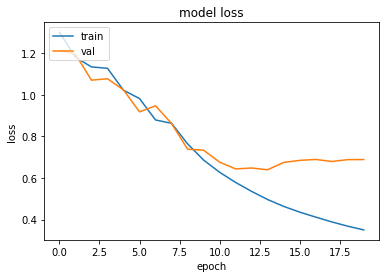

In [173]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [166]:
MSE.loc[12] = ["LSTM_HP_WITH_ACT"] + [M12]
MSE

,MODEL,MSE
0,Mean-based baseline,1.414214
1,TFIDF,1.006146
2,LOG-Reg,1.196488
3,SIMPLE-With-ACTIVATION,1.303524
4,SIMPLE-NO-ACTIVATION,4.407636
5,CNN-Simple-NO-ACTIVATION,0.922910
6,CNN-WITH-ACTIVATION,0.875534
7,LSTM-NO-ACTIVATION,0.690894
8,LSTM-WITH-ACTIVATION,0.689199
9,CNN_HP_NO_ACT,0.743151


In [169]:
tf.keras.models.save_model(model12, './lstm_model')
shutil.make_archive('lstm_model.zip', 'zip', './lstm_model')

2021-05-02 00:10:45,147 : WARNING : Found untraced functions such as lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_fn, lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 5 of 5). These functions will not be directly callable after loading.
2021-05-02 00:10:45,188 : WARNING : Found untraced functions such as lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_fn, lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 5 of 5). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./lstm_model\assets


2021-05-02 00:10:45,606 : INFO : Assets written to: ./lstm_model\assets


'C:\\Users\\alita\\Desktop\\MLProject\\TypeA_Review_Crystal_Ball\\TypeA_Review_Crystal_Ball\\lstm_model.zip.zip'

# Predict

In [145]:
raw = pd.read_csv('Test.csv')
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"n't", ' not', text)
    text = re.sub(r"\W|[\r\n]+", ' ', text) # remove not-words and newlines
    text = re.sub(r"\s{2,}", ' ', text) # remove '.', ',' and doubled whitespaces
    
    tokenized = [word for word in text.split() if word not in stopwords.words('english')] # remove stopwords
    text = ' '.join(tokenized)
    return text
dft = raw
dft['Review'] = dft['reviewText'] + dft["summary"]


dft['Review'] = dft['Review'].map(preprocess_text)
#dft['Review_length'] = dft['reviewText'].map(lambda x: len(x.split()))

In [151]:
dft.drop(["reviewText","reviewTime","reviewerID","summary"], axis = 1)

,ProductID,Rating,Review,Review_length
0,B00BO2AAOE,5,fell love cover book looked enchanting found b...,179
1,B00H0V05AM,3,good short novel seem much passion use c arthu...,39
2,B00HWHZOA0,3,yesterday waiting receive borrowed book little...,130
3,B00H9GMPYM,1,drags new one last page waste time could skipp...,21
4,B00A9NYDV0,3,set pretty snapshots seen better pictures colo...,50
...,...,...,...,...
10245,B00B92ZIKU,2,book strange concept interesting really catch ...,26
10246,B00CF75HDQ,2,beck call quite box novel based dominatrix lif...,128
10247,B00HFHKK1K,4,enjoyed political thriller set balkan conflict...,89
10248,B00CTSNQMU,4,finished firecracker heat liked trixie cy cute...,217


In [152]:

x_t = dft['Review']
y_t = dft["Rating"]
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(a)


x_t = tokenizer.texts_to_sequences(x_t)



x_t = pad_sequences(x_t, padding='post', maxlen=MAX_VECTOR_LEN)

In [153]:
y_pred = model3.predict(x_t)
y_pred[y_pred>5] =5
y_pred[y_pred<=1] =1
mean_squared_error(y_t, y_pred)

1.3289242329232298

In [154]:
y_pred = model4.predict(x_t)
y_pred[y_pred>5] =5
y_pred[y_pred<=1] =1
mean_squared_error(y_t, y_pred)

2.1093038308320717

In [157]:
y_pred = model5.predict(x_t)
y_pred[y_pred>5] =5
y_pred[y_pred<=1] =1
mean_squared_error(y_t, y_pred)

0.8762943187950439

In [158]:
y_pred = model6.predict(x_t)
y_pred[y_pred>5] =5
y_pred[y_pred<=1] =1
mean_squared_error(y_t, y_pred)

0.8590734623687785

In [159]:
y_pred = model7.predict(x_t)
y_pred[y_pred>5] =5
y_pred[y_pred<=1] =1
mean_squared_error(y_t, y_pred)

0.7042983293603089

In [160]:
y_pred = model8.predict(x_t)
y_pred[y_pred>5] =5
y_pred[y_pred<=1] =1
mean_squared_error(y_t, y_pred)

0.6923027910634606

In [161]:
y_pred = model9.predict(x_t)
y_pred[y_pred>5] =5
y_pred[y_pred<=1] =1
mean_squared_error(y_t, y_pred)

0.7324647615258044

In [162]:
y_pred = model10.predict(x_t)
y_pred[y_pred>5] =5
y_pred[y_pred<=1] =1
mean_squared_error(y_t, y_pred)

0.7461432419481674

In [163]:
y_pred = model11.predict(x_t)
y_pred[y_pred>5] =5
y_pred[y_pred<=1] =1
mean_squared_error(y_t, y_pred)

0.6631409682385659

In [165]:
y_pred = model12.predict(x_t)
# y_pred[y_pred>5] =5
# y_pred[y_pred<=1] =1
mean_squared_error(y_t, y_pred)

0.641590153639437

In [170]:
raw["predict"] = y_pred

In [171]:
raw.to_csv('Predict.csv', encoding='utf-8')

In [172]:
raw

,ProductID,reviewText,reviewTime,reviewerID,summary,Rating,Review,Review_length,predict
0,B00BO2AAOE,"I fell in love with the cover of this book, it...",17-Feb-46,A1K97SVHGTBP0E,Beautiful little book,5,fell love cover book looked enchanting found b...,179,3.884378
1,B00H0V05AM,It was a good short novel. It just didn't see...,22-Aug-46,A2QPY7AWL38XY8,Not as much of the passion...,3,good short novel seem much passion use c arthu...,39,2.889824
2,B00HWHZOA0,"Yesterday, I was waiting to receive a borrowed...",17-Apr-48,A2TNY4OUWVTJ0F,NOT MUCH TO WORK WITH BUT IT WAS CUTE...,3,yesterday waiting receive borrowed book little...,130,3.037555
3,B00H9GMPYM,Same drags on. The only New to this one is th...,28-Jun-46,A39WYE2YM9GPX4,REALLY lame,1,drags new one last page waste time could skipp...,21,1.195877
4,B00A9NYDV0,"A set of pretty snapshots, but I've seen bette...",28-Jul-46,ACJ6AI4DTHHO8,Just Snapshots,3,set pretty snapshots seen better pictures colo...,50,1.655985
...,...,...,...,...,...,...,...,...,...
10245,B00B92ZIKU,This book was very strange. The concept was in...,23-Jun-45,ADO2WO1WV0KV5,Could have been better,2,book strange concept interesting really catch ...,26,1.816872
10246,B00CF75HDQ,"At Her Beck and Call is quite an ""out of the b...",26-Oct-45,A3OH40OUL0PF85,Fast read,2,beck call quite box novel based dominatrix lif...,128,3.173508
10247,B00HFHKK1K,I enjoyed this political thriller set during t...,22-Mar-46,A374E849SQ2DB1,Fast-paced with good twists to keep you reading,4,enjoyed political thriller set balkan conflict...,89,3.679081
10248,B00CTSNQMU,I just finished Firecracker in Heat and I like...,28-Aug-45,A2XWNFCQ9U8N3S,Liked it,4,finished firecracker heat liked trixie cy cute...,217,3.640111
